In [1]:
%reload_ext autoreload
%autoreload 2

import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import ast
from skimage import io
from skimage.color import gray2rgb
from tqdm import tqdm
from collections import defaultdict
from scipy.interpolate import UnivariateSpline

In [42]:
HOME = os.path.expanduser("~")
DIR = os.path.join(HOME, 'programming/pipeline_utility')
sys.path.append(DIR)
from utilities.contour_utilities import get_contours_from_annotations, add_structure_to_neuroglancer, \
    create_full_volume, get_structure_colors
from utilities.sqlcontroller import SqlController
animal = 'MD589'
sqlController = SqlController(animal)
color_radius = 3
xy_ng_resolution_um = 5
color_radius = 3

CSV_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/foundation_brain_annotations'
csvfile = os.path.join(CSV_PATH, f'{animal}_annotation.csv')
hand_annotations = pd.read_csv(csvfile)
hand_annotations['vertices'] = hand_annotations['vertices'] \
    .apply(lambda x: x.replace(' ', ','))\
    .apply(lambda x: x.replace('\n',','))\
    .apply(lambda x: x.replace(',]',']'))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ','))\
    .apply(lambda x: x.replace(',,', ',')).apply(lambda x: x.replace(',,', ','))

hand_annotations['vertices'] = hand_annotations['vertices'].apply(lambda x: ast.literal_eval(x))

In [105]:
df = hand_annotations[['name', 'section', 'side', 'vertices']].copy()
R = df['name'] == "R"
RMC = df['name'] == "RMC"
VTA = df['name'] == "VTA"
df = df[R | RMC | VTA]
df = df.reset_index()
df = df.sort_values(by=['name', 'section'])
outpath = os.path.join(DIR, 'cvat', 'r_rmc_vta.csv')
#df.to_csv(outpath, index=False, columns=['name', 'section', 'side'])
df.head(1)

,index,name,section,side,vertices
54,1908,R,190,L,"[[21970.54123866, 11536.7946962], [21795.56575..."


In [109]:
first_section = df['section'].min()
last_section = df['section'].max()
last_section - first_section

78

In [107]:
df['section'].max()

268

In [77]:
#structures = list(hand_annotations['name'].unique())
structures = ['R', 'RMC', 'VTA']
section_structure_vertices = defaultdict(dict)
for structure in tqdm(structures):
    contour_annotations, first_sec, last_sec = get_contours_from_annotations(animal, structure, df, densify=0)
    for section in contour_annotations:
        section_structure_vertices[section][structure] = contour_annotations[section][structure][1]

100%|██████████| 3/3 [00:00<00:00, 233.69it/s]


In [108]:
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.5
thickness = 1
colors = {}
colors['R'] = (255,0,0)
colors['RMC'] = (0,0,0)
colors['VTA'] = (0,0,255)

section_images = {}
SCALE = 32
PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/CH1'
OUTPUT = os.path.join(PATH, 'r_rmc_vta')
os.makedirs(OUTPUT, exist_ok=True)
thumbnail_dir = os.path.join(PATH, 'thumbnail')
files = sorted(os.listdir(thumbnail_dir))
for file_name in tqdm(files):
    filepath = os.path.join(thumbnail_dir, file_name)
    #img = io.imread(filepath)
    img = cv2.imread(filepath)
    section = int(file_name.split('.')[0])
    
    for structure in section_structure_vertices[section]:
        pts = section_structure_vertices[section][structure]
        points = np.array(pts, dtype=np.int32)
        
        point_arr = np.array(pts,dtype=np.float64)
        x = np.array([v[0] for v in point_arr])
        y = np.array([v[1] for v in point_arr])
        midx = int((sum(x) // len(point_arr)) // SCALE)
        midy = int((sum(y) // len(point_arr)) // SCALE)
        midx = int(min(x) // SCALE)
        midy = int(min(y) // SCALE)
        """
        old_len = points.shape[0]
        new_len = int(old_len * 1)
        indexes = np.arange(0, old_len)
        new_indexes = np.linspace(0,old_len-1, new_len)
        splx = UnivariateSpline(indexes,x,k=3,s=0)
        x_smooth = splx(new_indexes)
        sply = UnivariateSpline(indexes,y,k=3,s=0)
        y_smooth = sply(new_indexes)
        points = np.column_stack((x_smooth, y_smooth)).astype(np.int32)
        """
        points = points // SCALE
        cv2.polylines(img, [points], isClosed=True, color=colors[structure], thickness=2)
        cv2.putText(img, structure, (midx,midy), font,
                    fontScale, colors[structure], thickness, cv2.LINE_AA)
        outpath = os.path.join(OUTPUT, file_name)
        cv2.imwrite(outpath, img)
        #for c in points:
        #    cv2.circle(img, (c[0],c[1]), 2, color, -1)
            
    section_images[section] = img

100%|██████████| 448/448 [00:06<00:00, 74.12it/s] 


In [69]:
len(files)

448

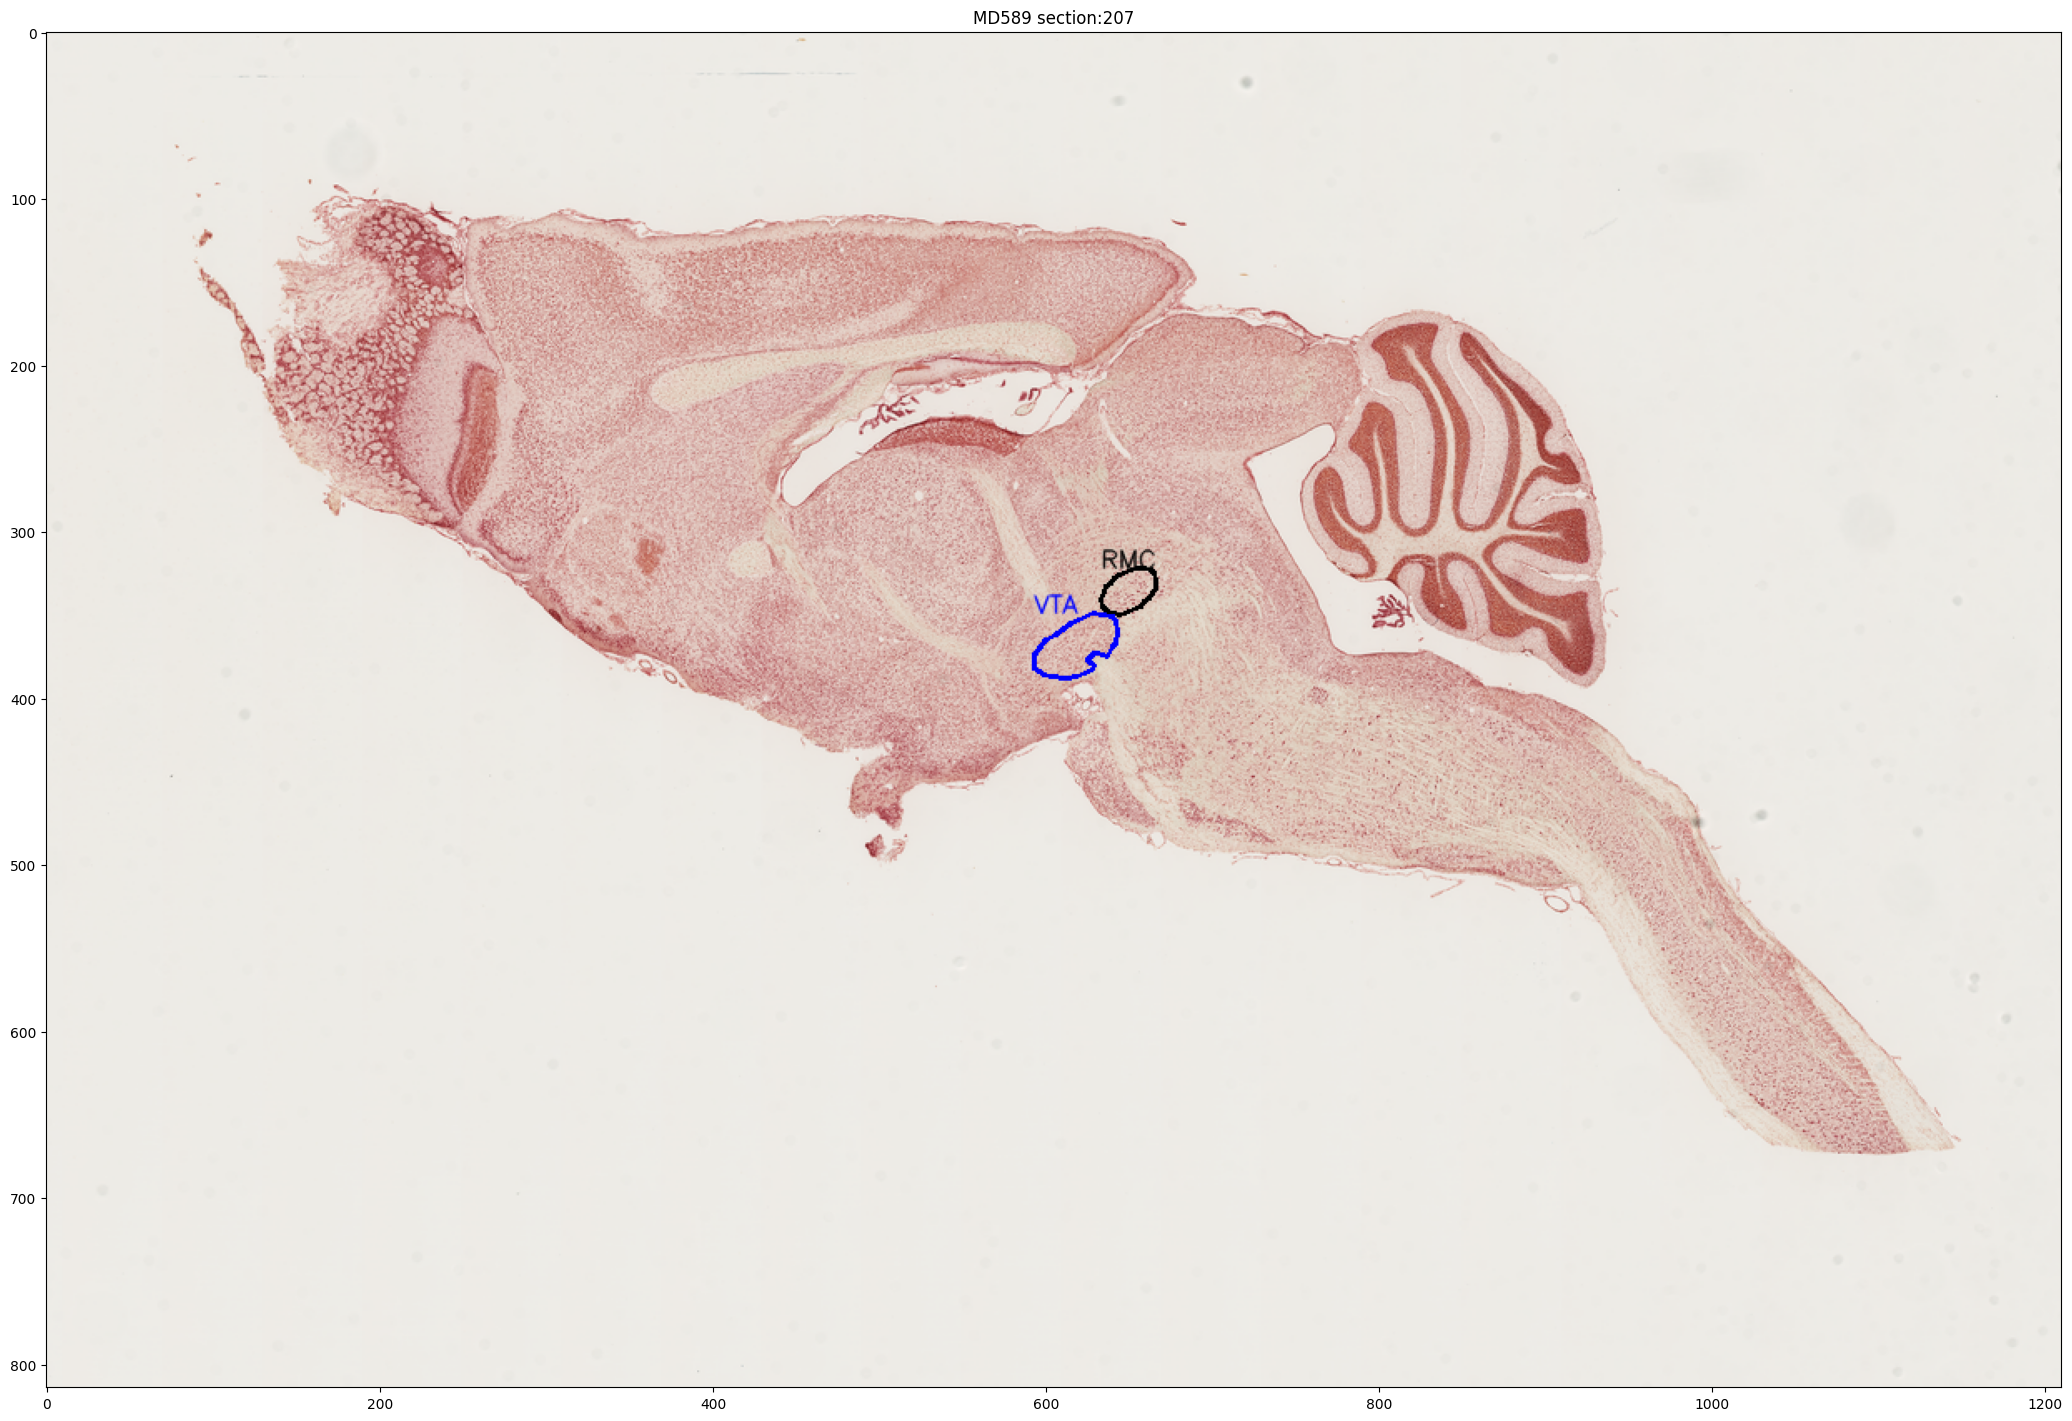

In [104]:
section = 207
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(section_images[section], cmap="cool")
plt.title('{} section:{}'.format(animal, section))
plt.show()

In [ ]:
filepath = os.path.join(HOME, '{}.tif'.format(section))
cv2.imwrite(filepath, section_images[section])

In [ ]:
#OUTPUT = os.path.join(PATH, 'annotations')
#os.makedirs(OUTPUT, exist_ok=True)
#for section in tqdm(section_images):
#    outpath = os.path.join(OUTPUT, str(section).zfill(3) + '.tif')
#    cv2.imwrite(outpath, section_images[section])